In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from jupyterthemes import jtplot #plots match theme
jtplot.style()
%config InlineBackend.figure_format = 'retina' #better quality plots

In [2]:
class Hernquist():
    """
    Hernquist model.
    """
    def __init__(self,G=1,M=1,c=1):
        self.c       = c
        self.G       = G
        self.M       = M
    def get_pot(self,r):
        c = self.c
        return -self.G*self.M/(r + c)
    def get_dphi_dr(self,r):
        c = self.c
        return self.G*self.M/(r + c)**2

In [3]:
class NFW():
    """
    NFW model.
    """
    def __init__(self,G=1,M=1,rs=1):
        self.rs   = rs
        self.G    = G
        self.M    = M
        self.rho0 = self.get_rho0()
    def get_rho0(self):
        rs = self.rs
        return self.M/(4*np.pi*np.power(rs,3)) 
    def get_pot(self,r):
        rs = self.rs
        return -(self.G*self.M)/r * np.log(1 + (r/rs)) 
    def get_dphi_dr(self,r):
        rs = self.rs
        return (self.G*self.M)/r * (np.log(1 + (r/rs))/r - (1/(rs + r))) 

In [4]:
class MN():
    """
    Miyamoto-Nagai model.
    """
    def __init__(self,a=1.0,b=1.0,G=1,M=1):
        self.a    = a
        self.b    = b
        self.G    = G
        self.M    = M
    def get_pot(self,R,z):
        return (-self.G*self.M)/(np.sqrt(R**2 + (np.sqrt(z**2 + self.b**2) + self.a)**2))
    def get_dphi_dR(self, R, z):
        return (self.G*self.M*R)/(R**2 + (self.a + np.sqrt(self.b**2 + z**2)**2))**(3/2)
    def get_dphi_dz(self, R, z):
        return (self.G*self.M*z*(self.a + np.sqrt(self.b**2 + z**2)))/((R**2 + (self.a + np.sqrt(self.b**2 + z**2))**2)**(3/2)*np.sqrt(self.b**2 + z**2))

In [15]:
# Initial conditions from gala:
# http://gala.adrian.pw/en/v1.2/potential/define-milky-way-model.html
# https://github.com/adrn/gala/blob/2fee111043604164bade00c9ac921629b8badf8b/gala/potential/potential/builtin/cybuiltin.pyx

G_const = 4.3e-6 # kpc km2 s-2 M⊙-1
log_M_h = np.log(6e11) # Msun
log_r_s = np.log(20.) # kpc
log_M_n = np.log(2e9) # Msun
log_a = np.log(100.*0.001) # kpc

MN_disk = MN(a=3.0, b=0.28, M=6.8e10, G=G_const) # converted b to kpc
Hern_bulge_sph = Hernquist(M=5e9, c=1, G=G_const) # assumed c in kpc
Hern_nucl_sph = Hernquist(M=np.exp(log_M_n), c=np.exp(log_a), G=G_const)
NFW_halo_sph = NFW(M=np.exp(log_M_h), rs=np.exp(log_r_s), G=G_const)

print(MN_disk.get_dphi_dz(45,0))

0.0


In [6]:
def sph_to_cart(dr,variables):
    """
    Converts from spherical accelerations to cartesian.
    """
    x = variables[0]
    y = variables[1]
    z = variables[2]
    r = variables[3]
    
    ax = -dr * (x/r)
    ay = -dr * (y/r)
    az = -dr * (z/r)
    return ax, ay, az

###################

def cyl_to_cart(dR,dz,variables):
    """
    Converts from cylindrical accelerations to cartesian.
    """
    x = variables[0]
    y = variables[1]
    R = variables[4]
    
    ax = -dR * (x/R)
    ay = -dR * (y/R)
    az = -dz
    return ax, ay, az

###################

def convert_coords(shape, **kwargs):
    """If spherical portential (sph), converts from spherical coordinates, 
    if cylindircal potential (disk), converts from cylindrical coordinates.
    """
    if shape=='sph':
        dr = kwargs.get('dphi_dr')
        variables = kwargs.get('variables')
        # Now I need to convert from spherical to cartesian 
        ax, ay, az = sph_to_cart(dr,variables)
        return ax, ay, az
    
    if shape=='disk':
        dR = kwargs.get('dphi_dR')
        dz = kwargs.get('dphi_dz')
        variables = kwargs.get('variables')
        # Now I need to convert from cylindrical to cartesian 
        ax, ay, az = cyl_to_cart(dR,dz,variables)
        return ax, ay, az

###################

def find_accel(potential, variables):    
    """
    Parameters
    ----------
    potential : str
        NFW_halo_sph, Hern_bulge_sph, Hern_nucl_sph, MN_disk, all
    x : array
        x-postions
    y : array
        y-postions
    z : array
        z-postions
    r : array (spherical coordinates)
        r-postions
    R : array
        R-postions (cylindrical coordinates)
    
        
    Returns
    ----------
    (due to chosen potential)
    ax : array
        x-accelerations 
    ay : array
        y-accelerations 
    az : array
        z-accelerations
    """
    
    x = variables[0]
    y = variables[1]
    z = variables[2]
    r = variables[3]
    R = variables[4]
    
    if potential=='NFW_halo_sph':
        ax, ay, az = convert_coords(potential.split('_')[2], dphi_dr=NFW_halo_sph.get_dphi_dr(r),
                                   variables=variables)
        pot = NFW_halo_sph.get_pot(r)
        return ax, ay, az
    
    if potential=='Hern_bulge_sph':
        ax, ay, az = convert_coords(potential.split('_')[2], dphi_dr=Hern_bulge_sph.get_dphi_dr(r),
                                   variables=variables)
        pot = Hern_bulge_sph.get_pot(r)
        return ax, ay, az
    
    if potential=='Hern_nucl_sph':
        ax, ay, az = convert_coords(potential.split('_')[2], dphi_dr=Hern_nucl_sph.get_dphi_dr(r),
                                   variables=variables)
        pot = Hern_nucl_sph.get_pot(r)
        return ax, ay, az
    
    if potential=='MN_disk':        
        ax, ay, az = convert_coords(potential.split('_')[1], dphi_dR=MN_disk.get_dphi_dR(R,z), 
                                    dphi_dz=MN_disk.get_dphi_dz(R, z), variables=variables)
        pot = MN_disk.get_pot(R,z)
        return ax, ay, az
    
    # There must be a better way to do this:
    if potential=='all':        
        # NFW_halo_sph
        ax1, ay1, az1 = convert_coords('sph', dphi_dr=NFW_halo_sph.get_dphi_dr(r),
                                   variables=variables)
        pot1 = NFW_halo_sph.get_pot(r)
        
        # Hern_bulge_sph
        ax2, ay2, az2 = convert_coords('sph', dphi_dr=Hern_bulge_sph.get_dphi_dr(r),
                                   variables=variables)
        pot2 = Hern_bulge_sph.get_pot(r)
        
        # Hern_nucl_sph
        ax3, ay3, az3 = convert_coords('sph', dphi_dr=Hern_nucl_sph.get_dphi_dr(r),
                                   variables=variables)
        pot3 = Hern_nucl_sph.get_pot(r)
        
        # MN_disk
        ax4, ay4, az4 = convert_coords('disk', dphi_dR=MN_disk.get_dphi_dR(R,z), 
                                    dphi_dz=MN_disk.get_dphi_dz(R, z), variables=variables)
        pot4 = MN_disk.get_pot(R,z)
        
        # Summing up all accelerations
        ax = ax1 + ax2 + ax3 + ax4
        ay = ay1 + ay2 + ay3 + ay4
        az = az1 + az2 + az3 + az4
        return ax, ay, az
    
    raise NameError(f"Given: {potential}, Expected string, one of: NFW_halo_sph, Hern_bulge_sph, Hern_nucl_sph, MN_disk, all")

In [7]:
# Referenced http://cvarin.github.io/CSci-Survival-Guide/leapfrog.html
# Units of potentials as I have defined them give units ~Gyr
# It is assumed the intial acceleration(s) are zero (can be modified)

def leapfrog(potential, x_0, y_0, z_0, vx_0, vy_0, vz_0, dt, N):
    """
    Parameters
    ----------
    potential : str
        NFW_halo_sph, Hern_bulge_sph, Hern_nucl_sph, MN_disk, all
    x_0  : int or float
        intial x-postion
    y_0  : int or float
        intial y-postion
    z_0  : int or float
        intial z-postion
    vx_0 : int or float
        intial x-velocity
    vy_0 : int or float
        intial y-veloctiy
    vz_0 : int or float
        intial z-velocity
    dt   : int or float
        timestep to increment over
    N    : int or float
        total number of (time)steps
    
        
    Returns
    ----------
    (due to chosen potential and time)
    x : array
        x-postions
    y : array
        y-postions
    z : array
        z-postions
    vx : array
        x-velocities
    vy : array
        y-velocities
    vz : array
        z-velocities
    ax : array
        x-accelerations 
    ay : array
        y-accelerations
    az : array
        z-accelerations
    """
    
    dt_ = dt
    t = np.arange(0,N*dt_,dt_)
    
    x = np.zeros(len(t))
    y = np.zeros(len(t))
    z = np.zeros(len(t))
    
    vx = np.zeros(len(t))
    vy = np.zeros(len(t))
    vz = np.zeros(len(t))
    
    ax = np.zeros(len(t))
    ay = np.zeros(len(t))
    az = np.zeros(len(t))
    
    x[0] = x_0
    y[0] = y_0
    z[0] = z_0
    
    vx[0] = vx_0
    vy[0] = vy_0
    vz[0] = vz_0
    
    ax[0] = 0
    ay[0] = 0
    az[0] = 0
    
    for i in range(len(t)-1):
    # Pass these along to next function
        variables = x[i], y[i], z[i], np.sqrt(x[i]**2 + y[i]**2), np.sqrt(x[i]**2 + y[i]**2 + z[i]**2)
        ax[i], ay[i], az[i] = find_accel(potential, variables)
        
        vx_plushalf = vx[i] + ax[i]*dt*(1/2)
        x[i+1] = x[i] + vx_plushalf*dt
        
        vy_plushalf = vy[i] + ay[i]*dt*(1/2)
        y[i+1] = y[i] + vy_plushalf*dt
        
        vz_plushalf = vz[i] + az[i]*dt*(1/2)
        z[i+1] = z[i] + vz_plushalf*dt
        
        variables = x[i+1], y[i+1], z[i+1], np.sqrt(x[i+1]**2 + y[i+1]**2), np.sqrt(x[i+1]**2 + y[i+1]**2 + z[i+1]**2)
        ax[i+1], ay[i+1], az[i+1] = find_accel(potential, variables)
        
        vx[i+1] = vx_plushalf + ax[i+1]*dt*(1/2)
        vy[i+1] = vy_plushalf + ay[i+1]*dt*(1/2)
        vz[i+1] = vz_plushalf + az[i+1]*dt*(1/2)
    return x, y, z, vx, vy, vz, ax, ay, az

In [25]:
#x, y, z, vx, vy, vz, ax, ay, az = leapfrog('all', 6, 0, 0, 0, 40, 0, 0.005, 100) # Working example

# Experimenting... Herc coords below.
x, y, z, vx, vy, vz, ax, ay, az = leapfrog('all', 84699.06301838*0.001, 50765.17036287*0.001, 78958.45060182*0.001,
                                           172.86159755, 86.22236088, 0.60765245, 0.005, 3000)

# Something is not quite right! Is km/s a problem for vx, vy, vz?
# But 1 km/s = 1.023 pc/Myr ≈ 1 kpc/Gyr? http://astroweb.case.edu/ssm/astroconstants.html


# Hercules coords:
#             x = 84699.06301838*0.001, y = 50765.17036287*0.001, z = 78958.45060182*0.001, 
#             vx = 172.86159755,       vy = 86.22236088,         vz = 0.60765245 

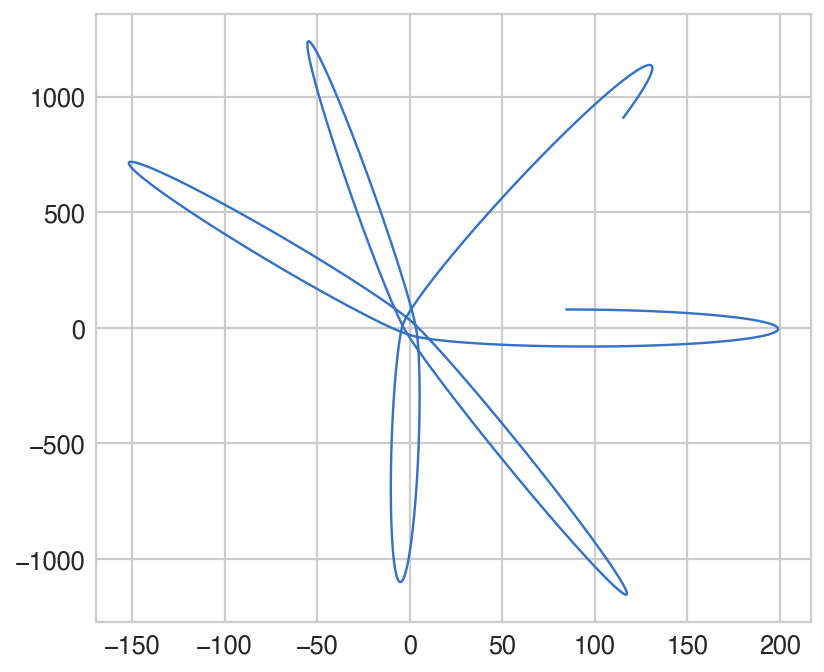

In [26]:
plt.plot(x,z) # Doesn't match gala ranges... Too large in x and z... Concerning!

In [10]:
r = np.sqrt(x**2 + y**2)
dr = -ax / (x/r)
vc = np.sqrt(dr * r) # http://www.sr.bham.ac.uk/~tjp/FEG/hand2.pdf Eqn. 2.3

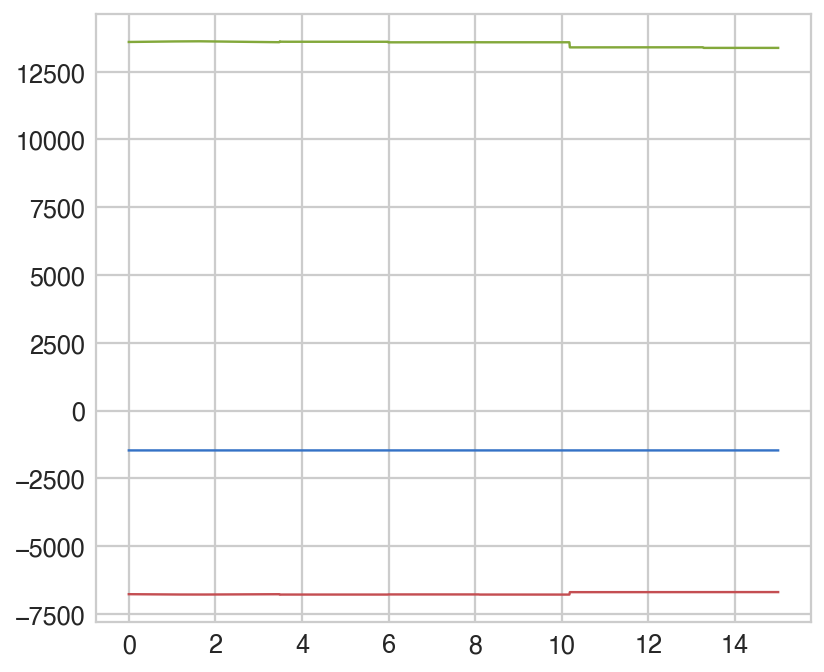

In [11]:
Lz = x*vy - y*vx
Ly = z*vx - x*vz
Lx = y*vz - z*vy

t = np.arange(0,3000*0.005,0.005)
plt.plot(t, Lz)
plt.plot(t, Ly)
plt.plot(t, Lx)

# Testing each component

## Hernquist

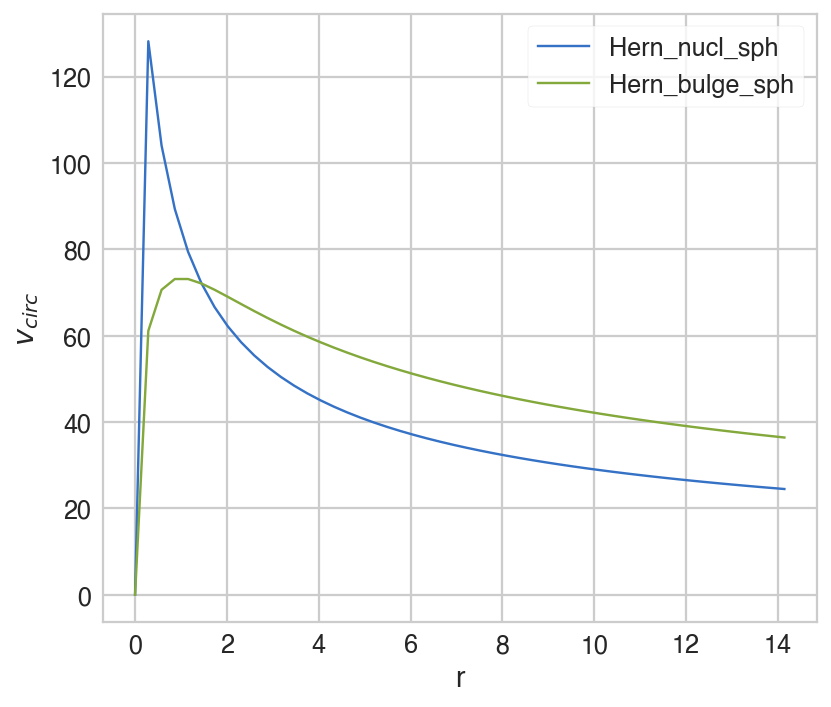

In [12]:
x = np.linspace(0.,10.,50)
y = np.linspace(0.,10.,50)

radii = [np.sqrt(x**2 + y**2), x, y]
plt.xlabel('r')
plt.ylabel('$v_{circ}$')

vcirc = np.sqrt(radii[0]*Hern_nucl_sph.get_dphi_dr(radii[0])) 
plt.plot(radii[0], vcirc, label='Hern_nucl_sph')

vcirc = np.sqrt(radii[0]*Hern_bulge_sph.get_dphi_dr(radii[0]))
plt.plot(radii[0], vcirc, label='Hern_bulge_sph')
plt.legend()

In [13]:
# Ignore for now! WiP...

values = radii[0]
xs = radii[1]
ys = radii[2]

ix = xs[5]
iy = ys[5]
iz = 0

# v_tangential = v_circ(?)
# This is v_r(?)
vrx = vcirc[5] * (ix/values[5]) 
vry = vcirc[5] * (iy/values[5])
vrz = vcirc[5] * (iz/values[5])

# v = sqrt(v_r**2 + v_tan**2)
ivx = np.sqrt(vrx**2 + vcirc[5]**2)
ivy = np.sqrt(vry**2 + vcirc[5]**2)
ivz = np.sqrt(vrz**2 + vcirc[5]**2)

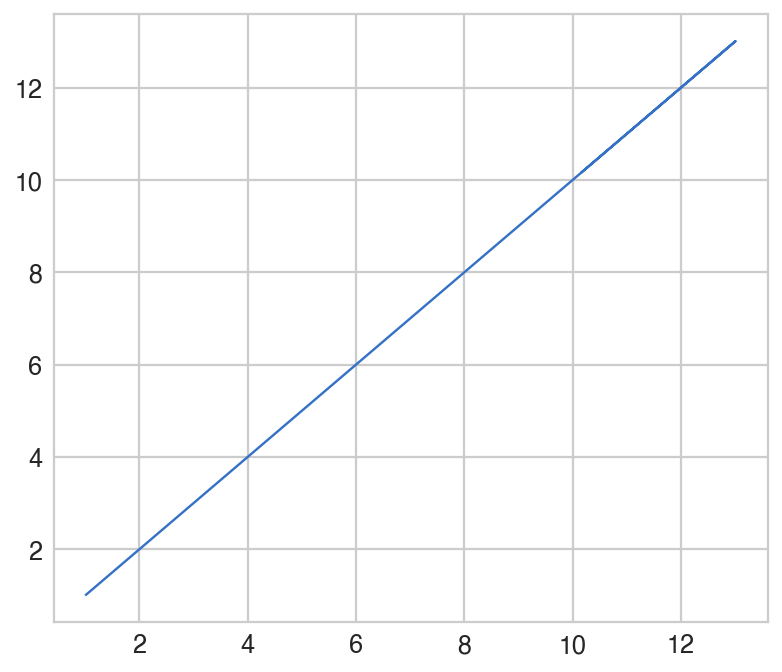

In [14]:
x, y, z, vx, vy, vz, ax, ay, az = leapfrog('Hern_bulge_sph', ix, iy, iz, ivx, ivy, ivz, 0.005, 200)
plt.plot(x,y) # Doesn't work! See cell below for working example...

In [15]:
x, y, z, vx, vy, vz, ax, ay, az = leapfrog('Hern_bulge_sph', 6, 0, 0, 0, 50, 0, 0.005, 200)

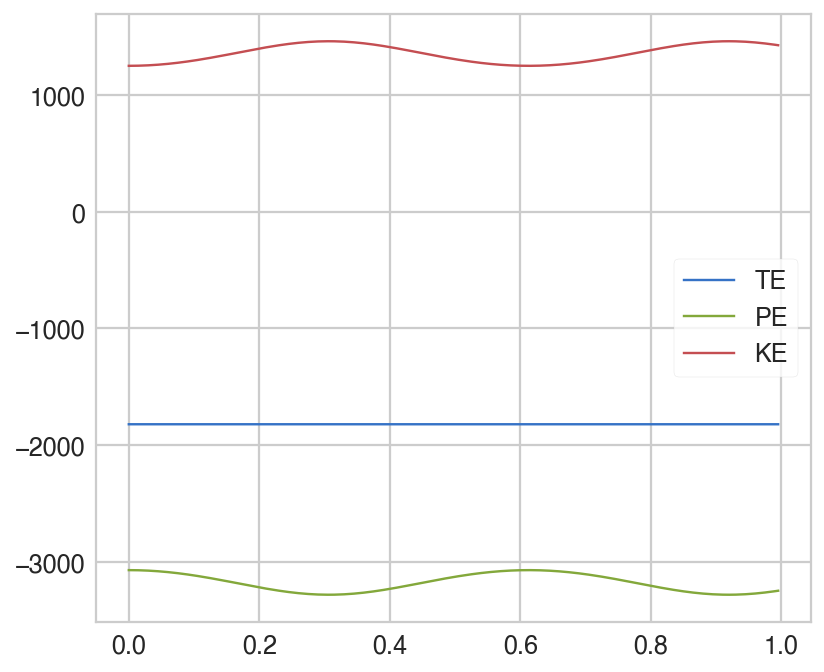

In [16]:
r_test = np.sqrt(x**2 + y**2 + z**2)
PE = Hern_bulge_sph.get_pot(r_test)
KE = 1/2*(vx**2 + vy**2 + vz**2)
TE = PE + KE
# print(r_test)
# print(Hern_nucl_sph.G)

t = np.arange(0,200*0.005,0.005)
plt.plot(t, TE, label='TE')
plt.plot(t, PE, label='PE')
plt.plot(t, KE, label='KE')

plt.legend()

0.0005381000465524721


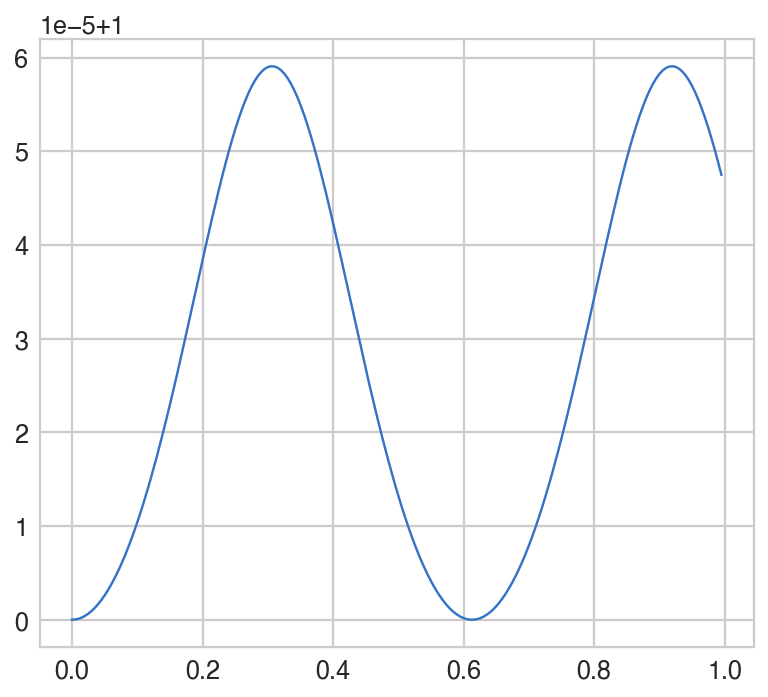

In [17]:
plt.plot(t, TE/TE[0])
print((max(TE)-min(TE))/len(TE))

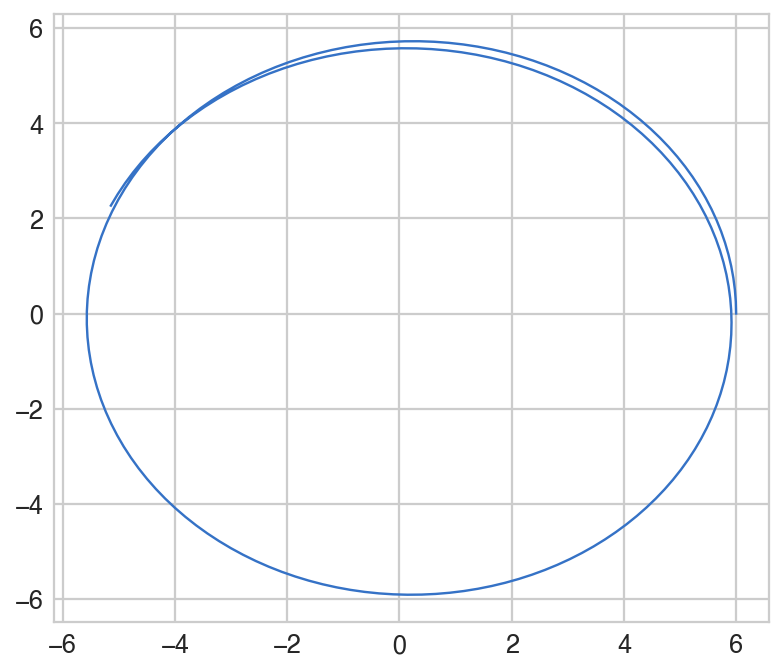

In [18]:
plt.plot(x,y)

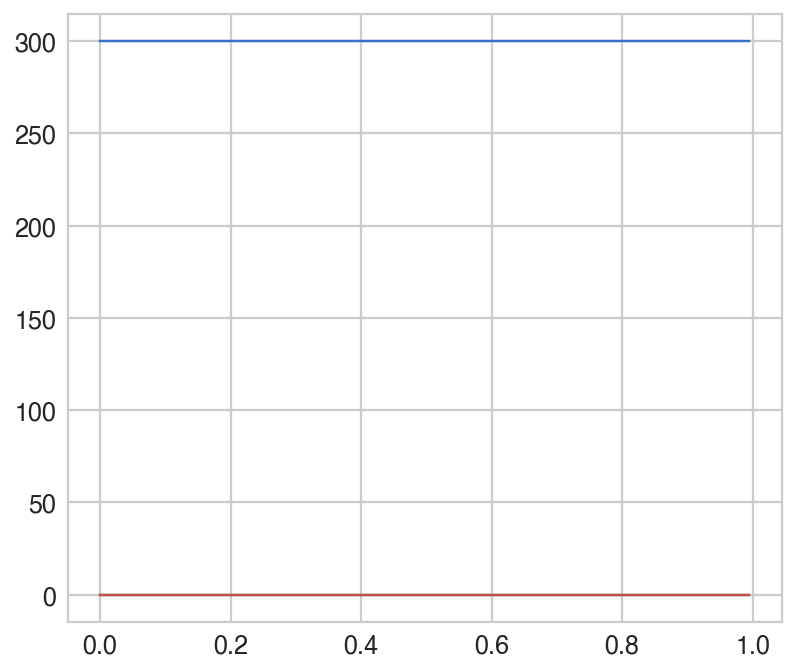

In [19]:
Lz = x*vy - y*vx
Ly = z*vx - x*vz
Lx = y*vz - z*vy

t = np.arange(0,200*0.005,0.005)
plt.plot(t, Lz)
plt.plot(t, Ly)
plt.plot(t, Lx)

## NFW

/var/folders/gh/_yjn9fmn44v1nwqyyfcq22ww0000gn/T/ipykernel_23846/3284546695.py:18: RuntimeWarning: divide by zero encountered in true_divide
  return (self.G*self.M)/r * (np.log(1 + (r/rs))/r - (1/(rs + r)))
/var/folders/gh/_yjn9fmn44v1nwqyyfcq22ww0000gn/T/ipykernel_23846/3284546695.py:18: RuntimeWarning: invalid value encountered in true_divide
  return (self.G*self.M)/r * (np.log(1 + (r/rs))/r - (1/(rs + r)))


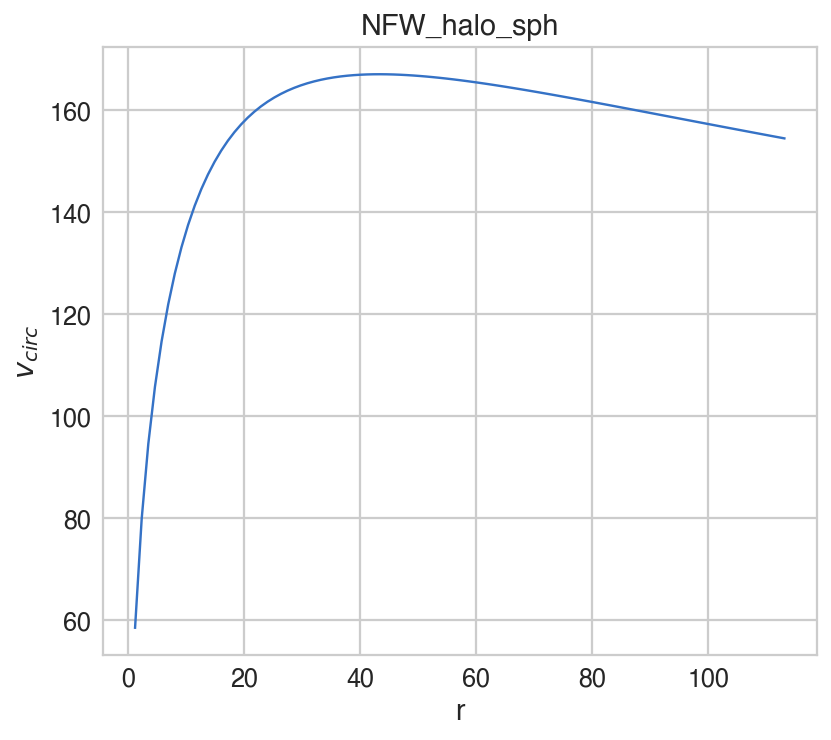

In [12]:
x = np.linspace(0.,80.,100)
y = np.linspace(0.,80.,100)

radii = [np.sqrt(x**2 + y**2), x, y]

plt.title('NFW_halo_sph')
plt.xlabel('r')
plt.ylabel('$v_{circ}$')
vcirc = np.sqrt(radii[0]*NFW_halo_sph.get_dphi_dr(radii[0]))
plt.plot(radii[0], vcirc)

In [13]:
x, y, z, vx, vy, vz, ax, ay, az = leapfrog('NFW_halo_sph', 20, 0, 0, 0, 160, 0, 0.005, 200)

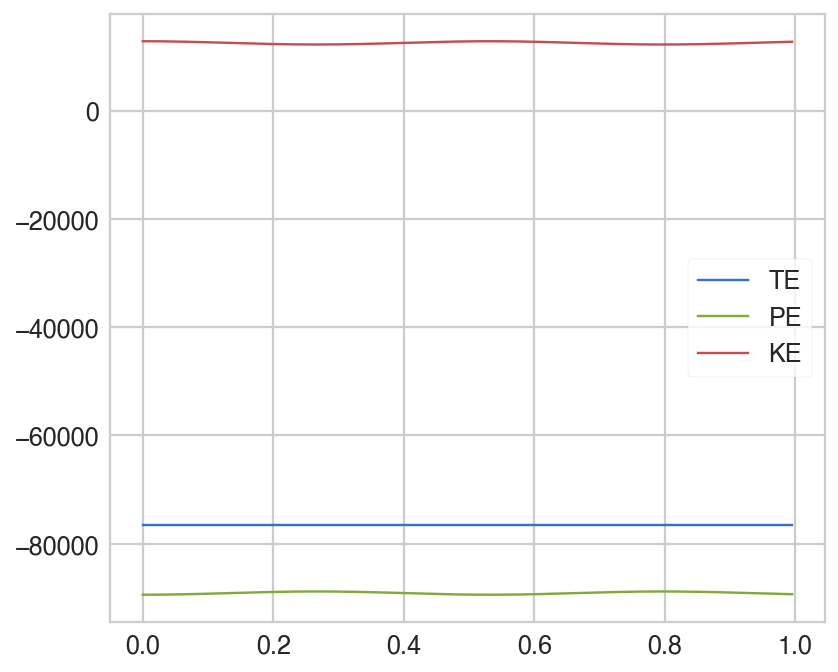

In [14]:
r_test = np.sqrt(x**2 + y**2 + z**2)
PE = NFW_halo_sph.get_pot(r_test)
KE = 1/2*(vx**2 + vy**2 + vz**2)
TE = PE + KE

t = np.arange(0,200*0.005,0.005)

plt.plot(t, TE, label='TE')
plt.plot(t, PE, label='PE')
plt.plot(t, KE, label='KE')

plt.legend()

0.0011472528953891015


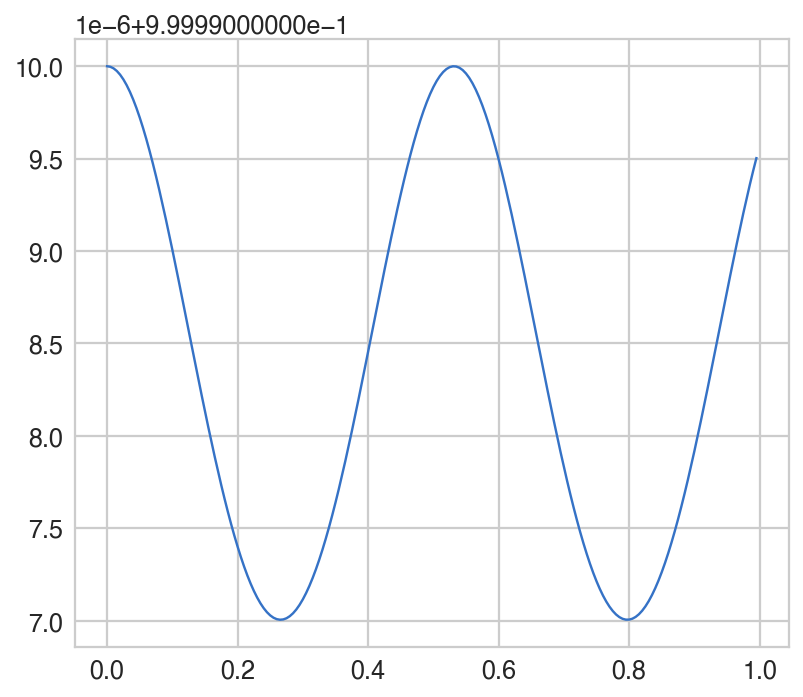

In [15]:
plt.plot(t, TE/TE[0])
print((max(TE)-min(TE))/len(TE))

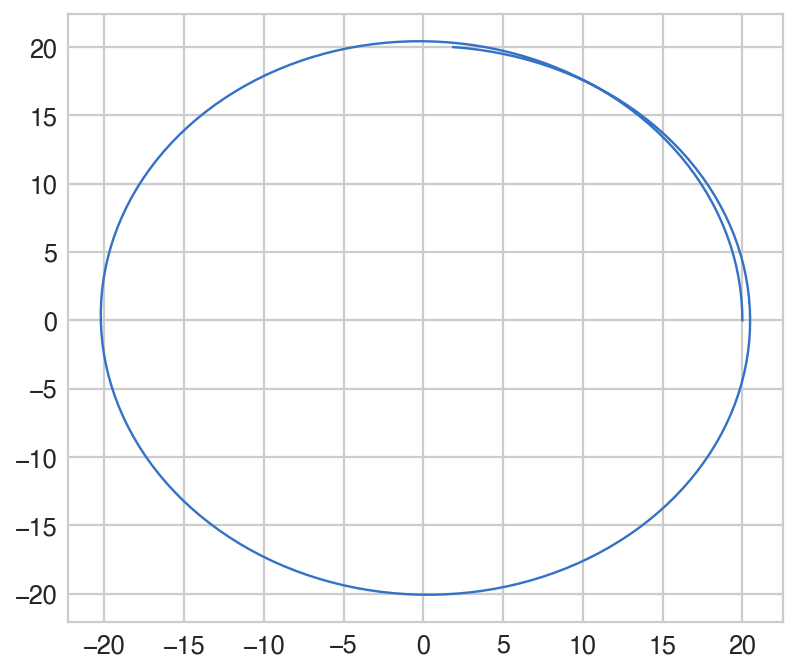

In [16]:
plt.plot(x,y)

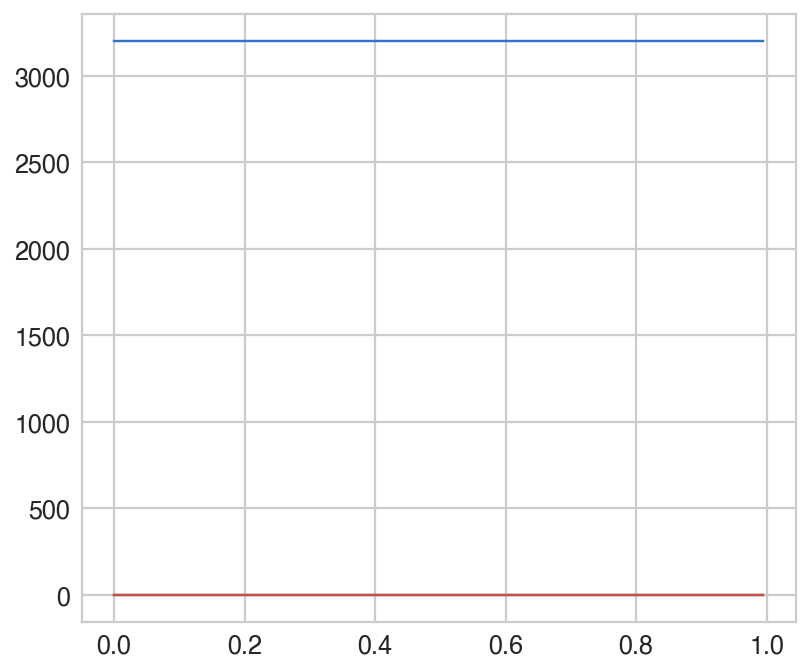

In [25]:
Lz = x*vy - y*vx
Ly = z*vx - x*vz
Lx = y*vz - z*vy

t = np.arange(0,200*0.005,0.005)
plt.plot(t, Lz)
plt.plot(t, Ly)
plt.plot(t, Lx)

## MN

[ 0.          1.14279884  2.28559768  3.42839651  4.57119535  5.71399419
  6.85679303  7.99959187  9.14239071 10.28518954]
[  0.         203.95138131 252.68963451 245.28630151 228.14450156
 211.43202423 196.91117873 184.56578873 174.05160356 165.02099159]


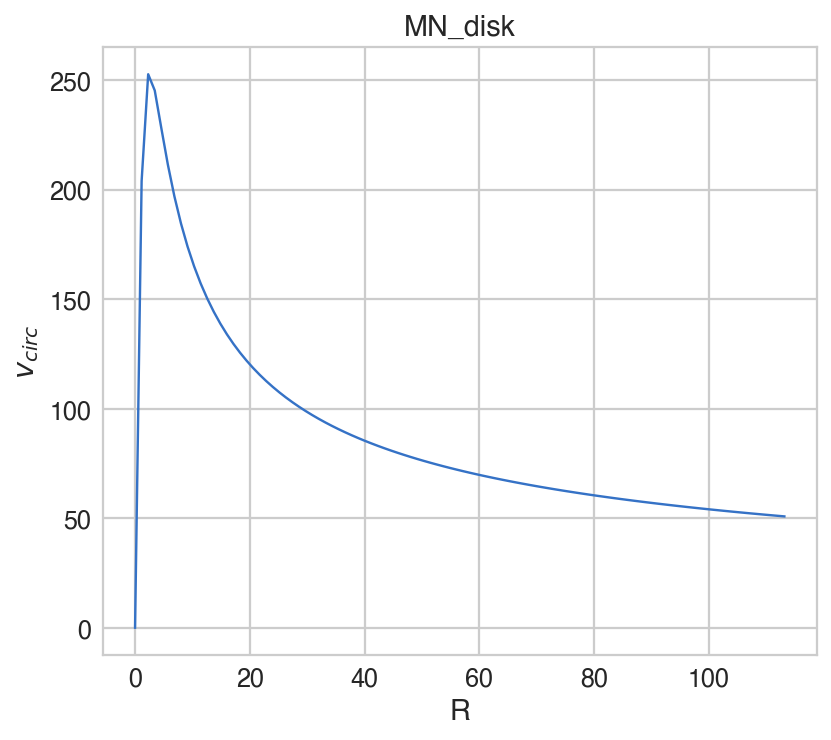

In [17]:
x = np.linspace(0.,80.,100)
y = np.linspace(0.,80.,100)

radii = [np.sqrt(x**2 + y**2), x, y]
z = 0

vcirc = np.sqrt(radii[0]*MN_disk.get_dphi_dR(radii[0], z))
plt.title('MN_disk')
plt.xlabel('R')
plt.ylabel('$v_{circ}$')
plt.plot(radii[0], vcirc)

print(radii[0][:10])
print(vcirc[:10])

In [8]:
x, y, z, vx, vy, vz, ax, ay, az = leapfrog('MN_disk', 10.2, 0, 0, 0, 165, 0, 0.0005, 2000)

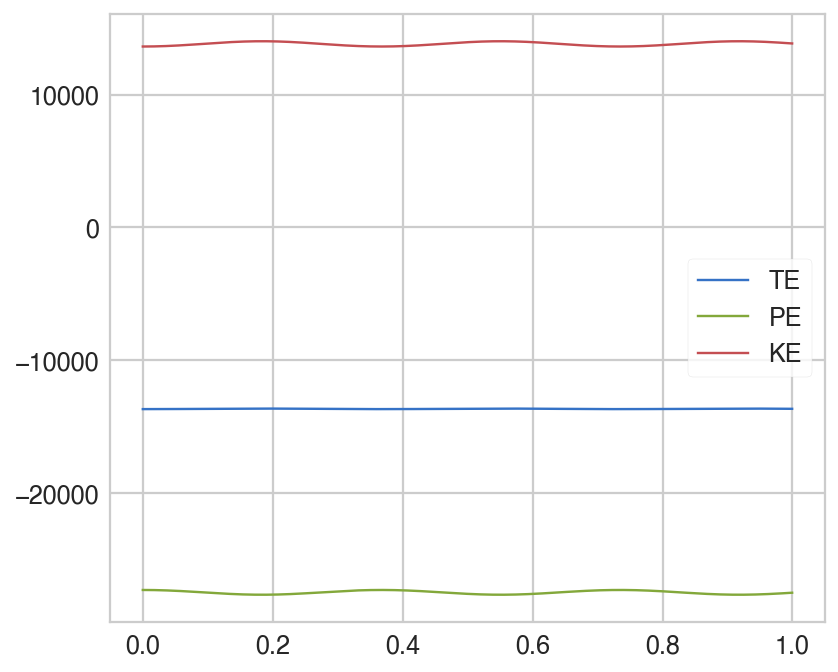

In [23]:
R_test = np.sqrt(x**2 + y**2)
PE = MN_disk.get_pot(R_test, z)
KE = 1/2*(vx**2 + vy**2)
TE = PE + KE

t = np.arange(0,2000*0.0005,0.0005)

plt.plot(t, TE, label='TE')
plt.plot(t, PE, label='PE')
plt.plot(t, KE, label='KE')

plt.legend()

0.01984300723443266


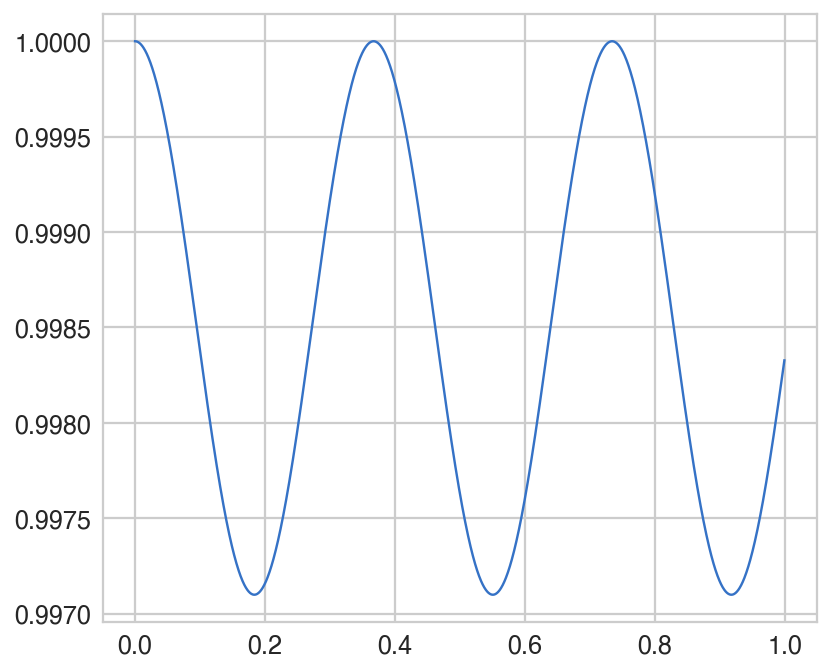

In [24]:
plt.plot(t, TE/TE[0])
print((max(TE)-min(TE))/len(TE)) 

0.15330642860766602


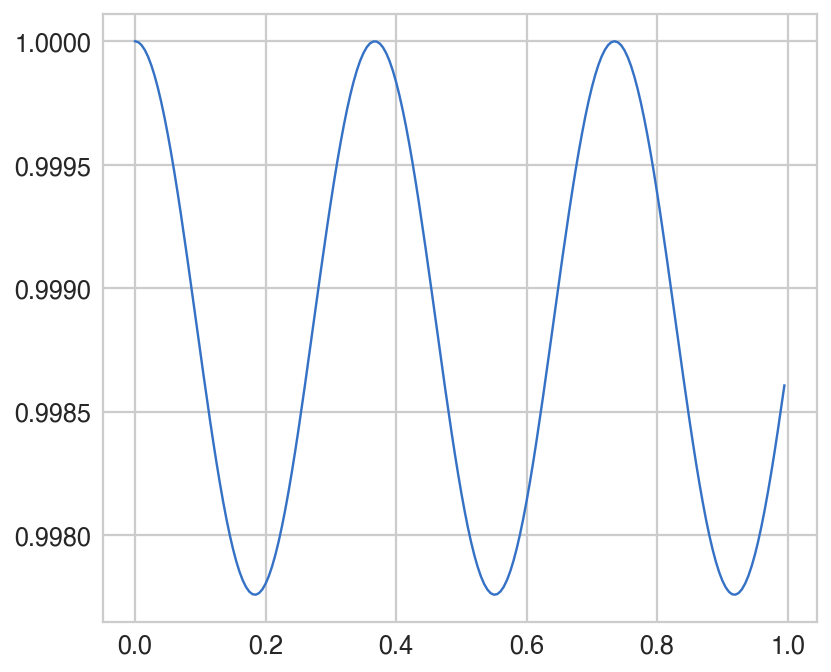

In [20]:
plt.plot(t, TE/TE[0])
print((max(TE)-min(TE))/len(TE)) # Why is this so big???

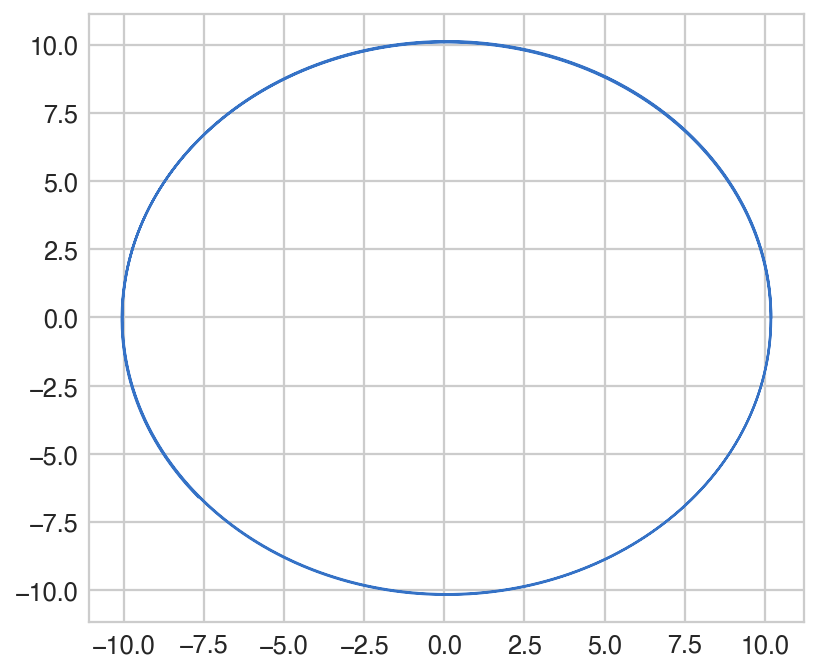

In [9]:
plt.plot(x,y)

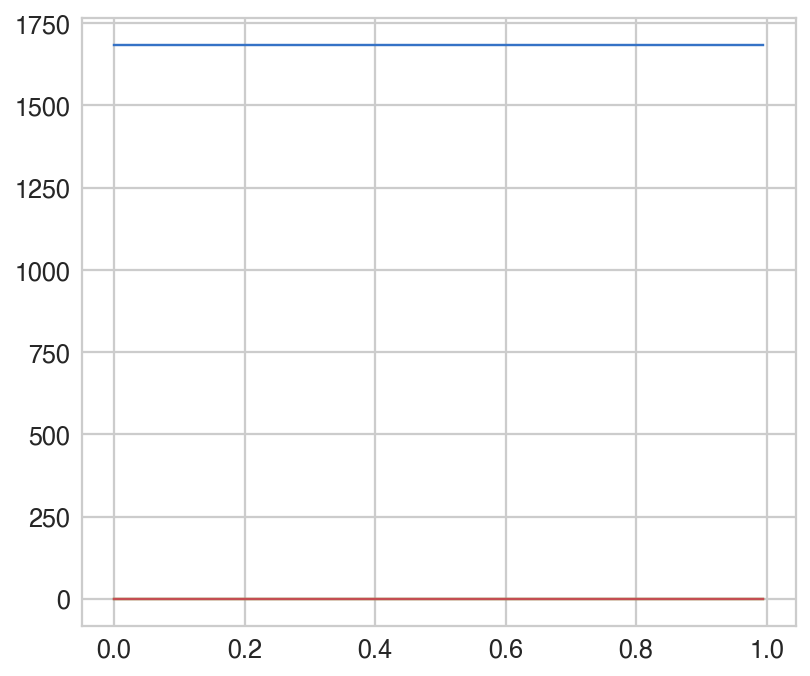

In [31]:
Lz = x*vy - y*vx
Ly = z*vx - x*vz
Lx = y*vz - z*vy

t = np.arange(0,200*0.005,0.005)
plt.plot(t, Lz)
plt.plot(t, Ly)
plt.plot(t, Lx)